# Baseline

In [1]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_validate
from sklearn import svm

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## __Описание данных__

- sample_submission.csv: пример файла-посылки
- train_raw_data.jsonl, test_raw_data.jsonl: "сырые" данные
- train_data.csv, test_data.csv: признаки, созданные авторами
- train_targets.csv: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "data/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [5]:
df_train_features.shape

(31698, 245)

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


In [7]:
df_train_targets.shape

(31698, 5)

In [8]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [10]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 24.9 s, sys: 144 ms, total: 25.1 s
Wall time: 3.38 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

In [11]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [12]:
y_pred[:10]

array([0.65471396, 0.54619925, 0.36613405, 0.58672188, 0.37730162,
       0.71243067, 0.48239938, 0.7819228 , 0.79553607, 0.49894522])

In [13]:
rf_model.predict(X_valid)[:10]

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 0], dtype=int8)

In [14]:
np.sum(rf_model.predict(X_valid) == y_valid)/len(y_valid)

0.6885383806519453

In [15]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [16]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


In [17]:
accuracy_score(y_valid, rf_model.predict(X_valid))

0.6885383806519453

## <left>Посылка

In [18]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [19]:
df_test_features.shape

(7977, 245)

In [20]:
df_test_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,0,0,0.000,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,8.664527,3,1,3,0,0.000,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.000000,2,1,2,0,0.250,0,0,0,0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,0.000000,0,0,1,0,0.125,0,0,0,0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,0.766459,0,0,1,0,1.000,0,0,0,0


In [21]:
df_submission.head()

,radiant_win_prob
match_id_hash,
a400b8f29dece5f4d266f49f1ae2e98a,0.528412
46a0ddce8f7ed2a8d9bd5edcbb925682,0.584583
b1b35ff97723d9b7ade1c9c3cf48f770,0.536272
ab3cc6ccac661a1385e73a2e9f21313a,0.517059
54aaab1cb8cc5df3c253641618673266,0.559372


In [22]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_20-50-19.csv


In [23]:
datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

'2022-04-03_20-50-19'

## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [24]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [25]:
cv

ShuffleSplit(n_splits=5, random_state=10801, test_size=0.3, train_size=None)

In [26]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 4.97 s, sys: 695 ms, total: 5.67 s
Wall time: 27.1 s


In [27]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [28]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [29]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
        
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [30]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [31]:
match['players'][0]

{'player_slot': 0,
 'hero_id': 31,
 'hero_name': 'npc_dota_hero_lich',
 'account_id_hash': '1c2500195e6ab646fc9371344724aa77',
 'ability_upgrades': [{'ability': 5136, 'time': 358, 'level': 1},
  {'ability': 5134, 'time': 437, 'level': 2},
  {'ability': 5136, 'time': 511, 'level': 3},
  {'ability': 5134, 'time': 578, 'level': 4},
  {'ability': 5134, 'time': 637, 'level': 5},
  {'ability': 5137, 'time': 713, 'level': 6},
  {'ability': 5135, 'time': 764, 'level': 7},
  {'ability': 5134, 'time': 839, 'level': 8},
  {'ability': 5136, 'time': 912, 'level': 9},
  {'ability': 6034, 'time': 981, 'level': 10},
  {'ability': 5136, 'time': 1038, 'level': 11},
  {'ability': 5137, 'time': 1106, 'level': 12},
  {'ability': 5135, 'time': 1185, 'level': 13},
  {'ability': 5135, 'time': 1417, 'level': 14},
  {'ability': 5135, 'time': 1689, 'level': 15},
  {'ability': 6112, 'time': 1875, 'level': 16}],
 'obs_placed': 1,
 'sen_placed': 0,
 'creeps_stacked': 0,
 'camps_stacked': 0,
 'rune_pickups': 3,
 'fi

In [32]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

In [33]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [34]:
df_train_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.000000,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.000000,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.250000,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.500000,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,0.000000,2,1,17,0,0.390244,2,2,0,0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,0.000000,6,2,10,0,0.263158,0,0,15,6
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,11.630505,0,0,15,1,0.555556,0,0,0,0


Информация о количестве использованных способностей:

In [35]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

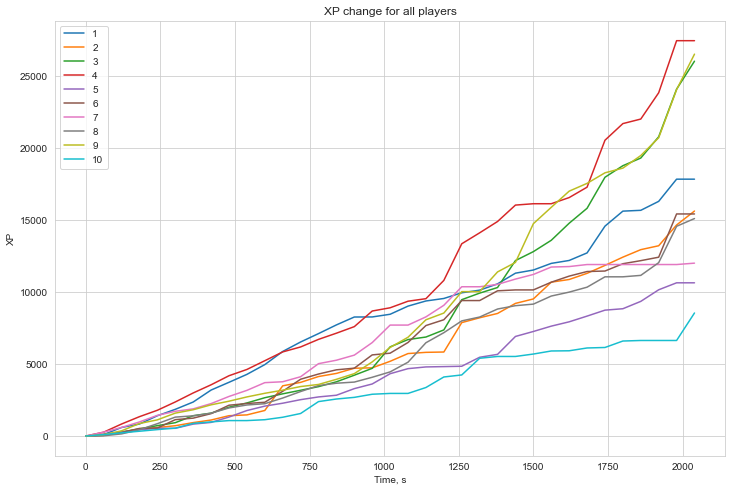

In [36]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

In [37]:
# Кажется, можно взять в качестве предиктора общее золото по команде. Как сумму всех 5 игроков
match['players'][8]['gold']

19859

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [38]:
!pip install ujson

In [39]:
!pip install tqdm

In [40]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргумент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [223]:
def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [42]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [43]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [44]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 90.3 ms, sys: 164 ms, total: 254 ms
Wall time: 41.9 s


In [45]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


In [46]:
rf_model.fit(df_train_features_extended.values, y)

RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

In [47]:
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [48]:
y_pred = rf_model.predict_proba(df_test_features_extended.values)[:, 1]

### Посылка

In [49]:
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))
X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(df_test_features_extended.values)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

  0%|          | 0/31698 [00:00<?, ?it/s]

In [50]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_20-52-44.csv


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

### Попробую добавить в модель общее золото по команде

In [121]:
def add_gold_var(df_features, matches_file, n_matches_to_read=None):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    for match in read_matches(matches_file, n_matches_to_read = n_matches_to_read):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_gold = 0
        dire_gold = 0 
        player = 0
        for i in range(len(match) + 1):
            if player < 5:
                dire_gold
                dire_gold+= match['players'][player]['gold']
            else:
                radiant_gold += match['players'][player]['gold']
            player += 1
        
        df_features.loc[match_id_hash, "radiant_gold"] = radiant_gold
        df_features.loc[match_id_hash, "dire_gold"] = dire_gold
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

__Let is check it works or not__

In [122]:
subs = df_train_features[:10]

In [123]:
subs.shape

(10, 245)

In [124]:
add_gold_var(subs,os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"), n_matches_to_read=10)

  0%|          | 0/31698 [00:00<?, ?it/s]

In [125]:
subs

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_gold,dire_gold
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,0.000000,0,0,0,0,13144.0,18172.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0,0.000000,0,0,0,0,480.0,880.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0,0.000000,0,0,0,0,1843.0,2947.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0,3,0,0.250000,0,0,3,0,20819.0,23650.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,1,0,1,0.500000,0,0,3,0,13418.0,12628.0
df50f738c454d430a33b2bf90cb9ef1a,636,22,7,1,5,74,1,1,0,3,...,0,1,0,0.428571,0,0,1,0,15938.0,11422.0
7469e9440ea3d19b211a484647c7126e,1054,22,0,8,5,71,1,3,10,4,...,0,11,0,0.636364,0,0,0,0,27107.0,27200.0
0aa1c6d7630433a93fe42da5ac810368,1797,22,7,9,2,35,1,5,2,1,...,0,19,0,0.371429,0,0,0,0,55254.0,50645.0
892b5d40992e4b334e159f99b2bb55e6,605,22,7,0,5,30,0,1,3,1,...,0,3,0,0.250000,0,0,1,0,12183.0,13431.0


In [126]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 1 строку
    for i in range(1):
        line = fin.readline()
        
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [127]:
count = 0
gold = 0
for player in match['players']:
    if count < 5:
        gold += player['gold']
    count += 1

gold

18172

Кажется, работает!

Посмотрим, что изменилось ли предсказание модели

In [129]:
# Скопируем таблицу с признаками
df_train_features_with_gold = df_train_features.copy()

# Добавим в нее общее золото по командам
add_gold_var(df_train_features_with_gold, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [130]:
df_train_features_with_gold.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_gold,dire_gold
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,0.00,0,0,0,0,13144.0,18172.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0,0.00,0,0,0,0,480.0,880.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0,0.00,0,0,0,0,1843.0,2947.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0,3,0,0.25,0,0,3,0,20819.0,23650.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,1,0,1,0.50,0,0,3,0,13418.0,12628.0


In [131]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_gold = cross_val_score(rf_model, df_train_features_with_gold.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 97.5 ms, sys: 188 ms, total: 285 ms
Wall time: 44.8 s


In [132]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")
print(f"ROC-AUC на кросс-валидации для признаков с золотом: {cv_scores_gold.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235
ROC-AUC на кросс-валидации для признаков с золотом: 0.773248028787058


Ой

Попробую все-таки закинуть решение

In [137]:
X_test.shape

(7977, 247)

In [140]:
rf_model.fit(df_train_features_with_gold.values,y)

RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

In [141]:
df_test_features_with_gold = df_test_features.copy()
add_gold_var(df_test_features_with_gold, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))
X_test = df_test_features_with_gold.values
y_test_pred = rf_model.predict_proba(df_test_features_with_gold.values)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features_with_gold.index)

  0%|          | 0/31698 [00:00<?, ?it/s]

In [142]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_22-19-36.csv


Кажется, очень странно, что общее количество денег по команде не улучшает модель

In [153]:
for col in df_train_features.columns:
    print(col)

game_time
game_mode
lobby_type
objectives_len
chat_len
r1_hero_id
r1_kills
r1_deaths
r1_assists
r1_denies
r1_gold
r1_lh
r1_xp
r1_health
r1_max_health
r1_max_mana
r1_level
r1_x
r1_y
r1_stuns
r1_creeps_stacked
r1_camps_stacked
r1_rune_pickups
r1_firstblood_claimed
r1_teamfight_participation
r1_towers_killed
r1_roshans_killed
r1_obs_placed
r1_sen_placed
r2_hero_id
r2_kills
r2_deaths
r2_assists
r2_denies
r2_gold
r2_lh
r2_xp
r2_health
r2_max_health
r2_max_mana
r2_level
r2_x
r2_y
r2_stuns
r2_creeps_stacked
r2_camps_stacked
r2_rune_pickups
r2_firstblood_claimed
r2_teamfight_participation
r2_towers_killed
r2_roshans_killed
r2_obs_placed
r2_sen_placed
r3_hero_id
r3_kills
r3_deaths
r3_assists
r3_denies
r3_gold
r3_lh
r3_xp
r3_health
r3_max_health
r3_max_mana
r3_level
r3_x
r3_y
r3_stuns
r3_creeps_stacked
r3_camps_stacked
r3_rune_pickups
r3_firstblood_claimed
r3_teamfight_participation
r3_towers_killed
r3_roshans_killed
r3_obs_placed
r3_sen_placed
r4_hero_id
r4_kills
r4_deaths
r4_assists
r4_denies


Попробую достать золото из .csv файла, может быть оно другое?!

In [151]:
radiant = ['r' + str(n) + '_gold' for n in range(1, 6)]
dire = ['d' + str(n) + '_gold' for n in range(1, 6)]
dire

['d1_gold', 'd2_gold', 'd3_gold', 'd4_gold', 'd5_gold']

И тут я прочитал чат, где говорят, что узнавать команду нужно по `player_slot`

In [173]:
for num, val in enumerate(match['players']):
    pl_id = val['player_slot']
    print(num, pl_id)

0 0
1 1
2 2
3 3
4 4
5 128
6 129
7 130
8 131
9 132


Хотя совпадает значение, то есть первые 5 – к 1 команде, другие – к другой

In [182]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 1 строку
    for i in range(73):
        line = fin.readline()
        
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

for num, val in enumerate(match['players']):
    pl_id = val['player_slot']
    print(num, pl_id)

0 0
1 1
2 2
3 3
4 4
5 128
6 129
7 130
8 131
9 132


Можно попробоватт, но вроде бы все совпадает

In [195]:
def add_gold_var2(df_features, matches_file, n_matches_to_read=None):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    for match in read_matches(matches_file, n_matches_to_read = n_matches_to_read):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_gold = 0
        dire_gold = 0 

        
        for player in match['players']:
            if len(str(player['player_slot'])) != 3:
                radiant_gold += player['gold']
            else:
                dire_gold += player['gold']
        
        df_features.loc[match_id_hash, "radiant_gold"] = radiant_gold
        df_features.loc[match_id_hash, "dire_gold"] = dire_gold
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [196]:
# Скопируем таблицу с признаками
df_train_features_with_gold = df_train_features.copy()

# Добавим в нее общее золото по командам
add_gold_var2(df_train_features_with_gold, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [197]:
df_train_features_with_gold.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_gold,dire_gold
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,0.00,0,0,0,0,18172.0,13144.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0,0.00,0,0,0,0,880.0,480.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0,0.00,0,0,0,0,2947.0,1843.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0,3,0,0.25,0,0,3,0,23650.0,20819.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,1,0,1,0.50,0,0,3,0,12628.0,13418.0


In [198]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_gold = cross_val_score(rf_model, df_train_features_with_gold.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 126 ms, sys: 319 ms, total: 444 ms
Wall time: 44.4 s


In [199]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")
print(f"ROC-AUC на кросс-валидации для признаков с золотом: {cv_scores_gold.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235
ROC-AUC на кросс-валидации для признаков с золотом: 0.7735031959918198


The same:(

In [200]:
match

{'game_time': 230,
 'match_id_hash': '538af79dd08dc1e6e278c3709bc5a665',
 'teamfights': [],
 'objectives': [{'time': 113.039,
   'type': 'CHAT_MESSAGE_FIRSTBLOOD',
   'slot': 9,
   'key': 1,
   'player_slot': 132}],
 'chat': [{'player_slot': 131, 'time': -82.58, 'text': '**** ****** ******'}],
 'game_mode': 22,
 'lobby_type': 7,
 'players': [{'player_slot': 0,
   'hero_id': 100,
   'hero_name': 'npc_dota_hero_tusk',
   'account_id_hash': 'b56fedc340772a9a0fed0c3c503a3016',
   'ability_upgrades': [],
   'obs_placed': 0,
   'sen_placed': 0,
   'creeps_stacked': 3,
   'camps_stacked': 1,
   'rune_pickups': 1,
   'firstblood_claimed': 0,
   'teamfight_participation': 0,
   'towers_killed': 0,
   'roshans_killed': 0,
   'observers_placed': 0,
   'stuns': 0,
   'max_hero_hit': {'type': 'max_hero_hit',
    'time': 2.066,
    'max': True,
    'inflictor': None,
    'unit': 'npc_dota_hero_tusk',
    'key': 'npc_dota_hero_monkey_king',
    'value': 52,
    'slot': 0,
    'player_slot': 0},
   't

Попробую рандомно немного поменять модель:

In [203]:
rf_model = RandomForestClassifier(n_estimators=250, max_depth=8, n_jobs=-1, random_state=SEED)

In [206]:
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_gold = cross_val_score(rf_model, df_train_features_with_gold.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_with_gold.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

In [207]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")
print(f"ROC-AUC на кросс-валидации для признаков с золотом: {cv_scores_gold.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.775678452199813
ROC-AUC на кросс-валидации для новых признаков: 0.7766409927061849
ROC-AUC на кросс-валидации для признаков с золотом: 0.7766409927061849


Кажется, что глубина дерева влияет на качество модели, когда в ней есть данные о деньгах, что кажется логично. Попробую еще чуть большее количество estimaters взять, хотя не больше 400, так как считаться будет долго

In [208]:
depths = [4,8,12,15,17]

In [209]:
for depth in depths:
    rf_model = RandomForestClassifier(n_estimators=350, max_depth=depth, n_jobs=-1, random_state=SEED)
    cv_scores_gold = cross_val_score(rf_model, df_train_features_with_gold.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"ROC-AUC на кросс-валидации для признаков с золотом при depth == {depth}: {cv_scores_gold.mean()}")

ROC-AUC на кросс-валидации для признаков с золотом при depth == 4: 0.757470072526399
ROC-AUC на кросс-валидации для признаков с золотом при depth == 8: 0.7766697311310171
ROC-AUC на кросс-валидации для признаков с золотом при depth == 12: 0.7848614909430098
ROC-AUC на кросс-валидации для признаков с золотом при depth == 15: 0.7861893716742216
ROC-AUC на кросс-валидации для признаков с золотом при depth == 17: 0.786428711563733


Вроде бы логично, что такая количестванная переменная, как количество денег сильно(?) начинает сильнее влиять при большем depth. Однако легко переобучиться. Попробую что-то побольше, а еще посомтрю как глубина сказывается на первоначальной модели:

Окей попробую еще с глубиной 20

In [210]:
rf_model = RandomForestClassifier(n_estimators=350, max_depth=30, n_jobs=-1, random_state=SEED)
cv_scores_gold = cross_val_score(rf_model, df_train_features_with_gold.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для признаков с золотом при depth == 30: {cv_scores_gold.mean()}")

ROC-AUC на кросс-валидации для признаков с золотом при depth == 30: 0.7852119890699015


О, уже хуже!
И __25__:

In [212]:
rf_model = RandomForestClassifier(n_estimators=350, max_depth=25, n_jobs=-1, random_state=SEED)
cv_scores_gold = cross_val_score(rf_model, df_train_features_with_gold.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для признаков с золотом при depth ==25 : {cv_scores_gold.mean()}")

ROC-AUC на кросс-валидации для признаков с золотом при depth ==25 : 0.7855210111841229


И __20__:

In [214]:
rf_model = RandomForestClassifier(n_estimators=450, max_depth=20, n_jobs=-1, random_state=SEED)
cv_scores_gold = cross_val_score(rf_model, df_train_features_with_gold.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для признаков с золотом при depth == 20 : {cv_scores_gold.mean()}")

ROC-AUC на кросс-валидации для признаков с золотом при depth == 20 : 0.7873832980011847


Похоже, глубина около 20 самая оптимальная

И первоначальная модель:

In [226]:
df_train_features_extended.head() # Ага, я ее поменял. Создам тогда заново

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [224]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [221]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [225]:
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")


ROC-AUC на кросс-валидации для новых признаков: 0.790823104763861


И эта лучше:( Все, что я сделал с голдой напрасно? Я думаю, это хорошо будет не в решающих деревьях. Пока засабмичу это решение

In [228]:
rf_model.fit(df_train_features_extended.values, y)

RandomForestClassifier(max_depth=20, n_estimators=450, n_jobs=-1,
                       random_state=10801)

In [229]:
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))
X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(df_test_features_extended.values)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

  0%|          | 0/31698 [00:00<?, ?it/s]

In [230]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-04_00-07-24.csv


И эта лучше:( Все, что я сделал с голдой напрасно? Я думаю, это хорошо будет не в решающих деревьях. Пока засабмичу это решение

Поработаю еще маленько с деревьями. Есть 2 идеи (я играл когда-то в доту 1, думаю, здесь принцип тот же): 1) попробовать добавить в модель суммарное ХР по команде и 2) количество вардов

In [250]:
def add_XP(df_features, matches_file, n_matches_to_read=None):
    """
    Добавляет в таблицуу суммарное ХР по командам (idk)
    """
    for match in read_matches(matches_file, n_matches_to_read = n_matches_to_read):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_xp = 0
        dire_xp = 0 

        
        for player in match['players']:
            if len(str(player['player_slot'])) != 3:
                radiant_xp += player['xp']
            else:
                dire_xp += player['xp']
        
        df_features.loc[match_id_hash, "radiant_xp"] = radiant_xp
        df_features.loc[match_id_hash, "dire_xp"] = dire_xp
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [247]:
match['players'][1]['xp']

268

In [249]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Сперва добавлю эту в лучшую модель на сейчас, а эта та, которая самая обычная с n_esimaters = 450, max_depth = 20

Еще есть не уверенность, что "хр" – это суммарное хр по персонажу

In [251]:
# Скопируем таблицу с признаками
df_train_features_with_xp = df_train_features.copy()

# Добавим в нее общее золото по командам
add_XP(df_train_features_with_xp, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [252]:
df_train_features_with_xp.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_xp,dire_xp
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,0.00,0,0,0,0,17566.0,12925.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0,0.00,0,0,0,0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0,0.00,0,0,0,0,2942.0,2513.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0,3,0,0.25,0,0,3,0,26116.0,27341.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,1,0,1,0.50,0,0,3,0,13044.0,13598.0


In [254]:
cv_scores_extended = cross_val_score(rf_model, df_train_features_with_xp.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для признаков с хр: {cv_scores_extended.mean()}")


ROC-AUC на кросс-валидации для признаков с хр: 0.7863219417095297


Опять же хуже, чем простая 

In [257]:
df_train_features_with_gold.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_gold,dire_gold
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,0.00,0,0,0,0,18172.0,13144.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0,0.00,0,0,0,0,880.0,480.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0,0.00,0,0,0,0,2947.0,1843.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0,3,0,0.25,0,0,3,0,23650.0,20819.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,1,0,1,0.50,0,0,3,0,12628.0,13418.0


Попробую объединить золото и хр :

In [258]:
# Скопируем таблицу с признаками
df_train_features_with_xp = df_train_features_with_gold.copy()

# Добавим в нее общее золото по командам
add_XP(df_train_features_with_xp, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [261]:
cv_scores_extended = cross_val_score(rf_model, df_train_features_with_xp.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для признаков с хр и золотом : {cv_scores_extended.mean()}")


ROC-AUC на кросс-валидации для признаков с хр и золотом : 0.7884661530121319


А теперь еще и с товерами :

In [272]:
df_gold_towers_xp = df_train_features_with_gold.copy()
df_gold_towers_xp['diff_tower_kills'] = df_train_features_extended['diff_tower_kills']
df_gold_towers_xp['radiant_xp'] = df_train_features_with_xp['radiant_xp']
df_gold_towers_xp['dire_xp'] = df_train_features_with_xp['dire_xp']
df_gold_towers_xp.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_gold,dire_gold,diff_tower_kills,radiant_xp,dire_xp
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.00,0,0,0,0,18172.0,13144.0,2.0,17566.0,12925.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.00,0,0,0,0,880.0,480.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.00,0,0,0,0,2947.0,1843.0,0.0,2942.0,2513.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0.25,0,0,3,0,23650.0,20819.0,0.0,26116.0,27341.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0.50,0,0,3,0,12628.0,13418.0,-1.0,13044.0,13598.0


In [274]:
cv_scores_extended = cross_val_score(rf_model, df_gold_towers_xp.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для признаков с хр и золотом и таверами : {cv_scores_extended.mean()}")


ROC-AUC на кросс-валидации для признаков с хр и золотом : 0.7913749918353873


О, пока что лучшая, засабмичу!

In [275]:
rf_model.fit(df_gold_towers_xp.values, y)

RandomForestClassifier(max_depth=20, n_estimators=450, n_jobs=-1,
                       random_state=10801)

In [287]:
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))
add_gold_var(df_test_features_extended,
            os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))
add_XP(df_test_features_extended,
            os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

df_test_features_extended.drop(['radiant_tower_kills', 'dire_tower_kills'], axis=1, inplace = True)
X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(df_test_features_extended.values)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

  0%|          | 0/31698 [00:00<?, ?it/s]

  0%|          | 0/31698 [00:00<?, ?it/s]

  0%|          | 0/31698 [00:00<?, ?it/s]

In [ ]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Однако на тесте несколько похуже, чем прошлая

Теперь думаю, что бессмысленно доставал варды, хр, так как это все есть в фичах .csv данных

In [294]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [302]:
match['targets']

{'game_time': 230,
 'duration': 2083,
 'time_remaining': 1853,
 'radiant_win': True,
 'next_roshan_team': None}

In [303]:
with open(os.path.join(PATH_TO_DATA, "test_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
        
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [306]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players'])

А я уже подумал, что можно считирить и достать из match `target` и засунуть `radiant_win` в модель

In [413]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

In [379]:
reg_model = LogisticRegression(C = 0.003)

In [391]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [380]:
cv_scores_extended = cross_val_score(reg_model, df_gold_towers_xp, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC в логистической регрессии на кросс-валидации для признаков с таверами : {cv_scores_extended.mean()}")


/Users/kirill/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kirill/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

ROC-AUC в логистической регрессии на кросс-валидации для признаков с таверами : 0.8074449409817872


/Users/kirill/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kirill/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

not bad

In [392]:
pipe.fit(df_gold_towers_xp.values, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [393]:
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))
add_gold_var(df_test_features_extended,
            os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))
add_XP(df_test_features_extended,
            os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

df_test_features_extended.drop(['radiant_tower_kills', 'dire_tower_kills'], axis=1, inplace = True)
X_test = df_test_features.values
y_test_pred = pipe.predict_proba(df_test_features_extended.values)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

  0%|          | 0/31698 [00:00<?, ?it/s]

  0%|          | 0/31698 [00:00<?, ?it/s]

  0%|          | 0/31698 [00:00<?, ?it/s]

что-то не то)

In [387]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-04_01-44-35.csv


Не успел разобраться с проблемой. Понял, что нужно заскейлить правильно, но пока не успел сделать.

In [421]:
# cv_scores_extended = cross_val_score(lin_mod, df_gold_towers_xp, y, 
#                                      cv=cv, scoring="roc_auc", n_jobs=-1)
# print(f"ROC-AUC в логистической регрессии на кросс-валидации для признаков с таверами : {cv_scores_extended.mean()}")
y_test_pred = lin_mod.predict(df_test_features_extended.values)
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier


# Кажется, что будет долго работать и навряд ли хорошо

# knn_model = KNeighborsClassifier(n_neighbors=30, p=2)

# cv_scores_extended = cross_val_score(knn_model, df_gold_towers_xp, y, 
#                                      cv=cv, scoring="roc_auc", n_jobs=-1)
# print(f"ROC-AUC в логистической регрессии на кросс-валидации для признаков с таверами : {cv_scores_extended.mean()}")


Ага, лучше даже не пробовать

Лучшее решение - отбирать признаки. А потом решать, какую модель брать. По факту я еще ни 1 признака не нашел,который бы как-то изменил модель в хорошую сторону.

In [406]:
for col in df_train_features.columns:
    print(col)

game_time
game_mode
lobby_type
objectives_len
chat_len
r1_hero_id
r1_kills
r1_deaths
r1_assists
r1_denies
r1_gold
r1_lh
r1_xp
r1_health
r1_max_health
r1_max_mana
r1_level
r1_x
r1_y
r1_stuns
r1_creeps_stacked
r1_camps_stacked
r1_rune_pickups
r1_firstblood_claimed
r1_teamfight_participation
r1_towers_killed
r1_roshans_killed
r1_obs_placed
r1_sen_placed
r2_hero_id
r2_kills
r2_deaths
r2_assists
r2_denies
r2_gold
r2_lh
r2_xp
r2_health
r2_max_health
r2_max_mana
r2_level
r2_x
r2_y
r2_stuns
r2_creeps_stacked
r2_camps_stacked
r2_rune_pickups
r2_firstblood_claimed
r2_teamfight_participation
r2_towers_killed
r2_roshans_killed
r2_obs_placed
r2_sen_placed
r3_hero_id
r3_kills
r3_deaths
r3_assists
r3_denies
r3_gold
r3_lh
r3_xp
r3_health
r3_max_health
r3_max_mana
r3_level
r3_x
r3_y
r3_stuns
r3_creeps_stacked
r3_camps_stacked
r3_rune_pickups
r3_firstblood_claimed
r3_teamfight_participation
r3_towers_killed
r3_roshans_killed
r3_obs_placed
r3_sen_placed
r4_hero_id
r4_kills
r4_deaths
r4_assists
r4_denies


Мне кажется, что можно редуцировать сам исходный датафрейм .csv:

In [409]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0
